# Home Energy Consumption Prediction Based on Smart Meter Data

## Problem Statement
Create a model to predict household energy consumption based on historical usage data and external factors like weather.

### Dataset Information
- **Source**: [UCI Household Power Consumption Dataset](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption)
- This dataset contains 2,075,259 measurements gathered in a house located in Sceaux (7 km from Paris, France) between December 2006 and November 2010 (47 months).

### Notes:
1. The formula `(global_active_power * 1000 / 60 - sub_metering_1 - sub_metering_2 - sub_metering_3)` represents the active energy consumed every minute (in watt hours) by electrical equipment not measured in sub-meterings 1, 2, and 3.
2. The dataset contains some missing values (approximately 1.25% of rows). A missing value is represented by the absence of value between two consecutive semi-colon attribute separators.

### Dataset Features:
- **household_power_consumption.txt**:
    - date: Date in format dd/mm/yyyy
    - time: Time in format hh:mm:ss
    - global_active_power: Household global minute-averaged active power (in kilowatt)
    - global_reactive_power: Household global minute-averaged reactive power (in kilowatt)
    - voltage: Minute-averaged voltage (in volt)
    - global_intensity: Household global minute-averaged current intensity (in ampere)
    - sub_metering_1: Energy sub-metering No. 1 {corresponds to kitchen containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered)}
    - sub_metering_2: Energy sub-metering No. 2 {corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light}
    - sub_metering_3: Energy sub-metering No. 3 {corresponds to an electric water-heater and an air-conditioner}


- **sceaux_weather_data.csv**: Collected weather data from meteostat api

| Code | Meaning                      |
|------|------------------------------|
| TIME | Date Recorded                |
| TAVG | Average Temperature          |
| TMIN | Minimum Temperature          |
| TMAX | Maximum Temperature          |
| PRCP | Total Precipitation          |
| SNOW | Snow Depth                   |
| WDIR | Wind (From) Direction        |
| WSPD | Average Wind Speed           |
| WPGT | Wind Peak Gust               |
| PRES | Sea-Level Air Pressure       |
| TSUN | Total Sunshine Duration      |

### Requirements
- **Data Preprocessing**: Clean and preprocess the datasets.
- **Feature Engineering**: Create meaningful features to improve model accuracy.
- **Model Evaluation**: Use metrics like RMSE, MAE, or R-squared to assess performance.

## Data Pre-processing

### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

%matplotlib inline

### Loading energy dataset

In [2]:
energy_df = pd.read_csv('household_power_consumption.csv', delimiter=',')
energy_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0,1,17.0
1,16/12/2006,17:25:00,5.36,0.436,233.63,23,0,1,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23,0,2,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23,0,1,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0,1,17.0


In [3]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Date                   1048575 non-null  object 
 1   Time                   1048575 non-null  object 
 2   Global_active_power    1048575 non-null  object 
 3   Global_reactive_power  1048575 non-null  object 
 4   Voltage                1048575 non-null  object 
 5   Global_intensity       1048575 non-null  object 
 6   Sub_metering_1         1048575 non-null  object 
 7   Sub_metering_2         1048575 non-null  object 
 8   Sub_metering_3         1044506 non-null  float64
dtypes: float64(1), object(8)
memory usage: 72.0+ MB


### Loading and Pre-Processing Weather Data

In [4]:
weather_df = pd.read_csv('sceaux_weather_data.csv')
weather_df.head()

,time,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2006-12-01,8.3,4.7,10.0,0.0,NaN,172.0,14.2,NaN,1024.6,NaN
1,2006-12-02,10.2,8.8,11.4,0.0,NaN,187.0,10.6,NaN,1017.1,NaN
2,2006-12-03,9.6,7.7,11.8,0.3,NaN,197.0,19.3,NaN,1008.2,NaN
3,2006-12-04,12.2,8.7,14.5,4.8,NaN,216.0,20.0,NaN,1006.7,NaN
4,2006-12-05,13.3,10.7,15.7,4.3,NaN,201.0,20.7,NaN,1004.5,NaN


In [5]:
# Convert 'time' column to datetime format
weather_df['time'] = pd.to_datetime(weather_df['time'])

In [6]:
# Extract day, month, and year from the time column
weather_df['Year'] = weather_df['time'].dt.year
weather_df['Month'] = weather_df['time'].dt.month
weather_df['Day'] = weather_df['time'].dt.day

### Pre-Processing Energy data

In [7]:
# Set dtypes
dtypes = {
    'Date': str,
    'Time': str,
    'Global_active_power': float,
    'Global_reactive_power': float,
    'Voltage': float,
    'Global_intensity': float,
    'Sub_metering_1': float,
    'Sub_metering_2': float,
    'Sub_metering_3': float
}
# Load energy data with proper dtypes
energy_df = pd.read_csv('household_power_consumption.csv', dtype=dtypes, delimiter=',', na_values="?")
energy_df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [8]:
# Combine 'Date' and 'Time' into a single datetime column
energy_df['Datetime'] = pd.to_datetime(energy_df['Date'] + ' ' + energy_df['Time'], format='%d/%m/%Y %H:%M:%S')

# Drop original date and time columns to clean up the dataset
energy_df.drop(columns=['Date', 'Time'], inplace=True)
energy_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00


### Merging the Datasets

In [9]:
# Merge datasets based on the datetime
merged_df = pd.merge(energy_df, weather_df, left_on='Datetime', right_on='time', how='inner')
# Drop the redundant 'time' column from the merged dataset
merged_df.drop(columns=['time'], inplace=True)
merged_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,tavg,tmin,...,prcp,snow,wdir,wspd,wpgt,pres,tsun,Year,Month,Day
0,1.044,0.152,242.73,4.4,0.0,2.0,0.0,2006-12-17,4.4,1.1,...,3.3,NaN,217.0,4.6,NaN,1029.5,NaN,2006,12,17
1,0.278,0.126,246.17,1.2,0.0,2.0,0.0,2006-12-18,4.6,3.4,...,0.0,NaN,125.0,6.5,NaN,1029.0,NaN,2006,12,18
2,0.414,0.242,241.19,2.0,0.0,1.0,0.0,2006-12-19,2.6,0.5,...,0.0,NaN,22.0,14.8,NaN,1034.1,NaN,2006,12,19
3,0.824,0.058,245.57,3.4,0.0,0.0,0.0,2006-12-20,2.9,0.5,...,0.0,NaN,21.0,13.5,NaN,1037.5,NaN,2006,12,20
4,1.814,0.148,243.51,7.6,0.0,0.0,18.0,2006-12-21,5.2,1.7,...,0.0,NaN,23.0,14.5,NaN,1039.4,NaN,2006,12,21


### Checking for missing values

In [10]:
# Check for missing values
merged_df.isnull().sum()

Global_active_power        2
Global_reactive_power      2
Voltage                    2
Global_intensity           2
Sub_metering_1             2
Sub_metering_2             2
Sub_metering_3             2
Datetime                   0
tavg                       0
tmin                       0
tmax                       0
prcp                       0
snow                     727
wdir                      16
wspd                       7
wpgt                     728
pres                      28
tsun                     728
Year                       0
Month                      0
Day                        0
dtype: int64

In [11]:
# Fill missing values using ffill method
merged_df.fillna(method='ffill', inplace=True)  # Forward fill to maintain continuity
merged_df.info() # Verify that there are no missing values left

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    728 non-null    float64       
 1   Global_reactive_power  728 non-null    float64       
 2   Voltage                728 non-null    float64       
 3   Global_intensity       728 non-null    float64       
 4   Sub_metering_1         728 non-null    float64       
 5   Sub_metering_2         728 non-null    float64       
 6   Sub_metering_3         728 non-null    float64       
 7   Datetime               728 non-null    datetime64[ns]
 8   tavg                   728 non-null    float64       
 9   tmin                   728 non-null    float64       
 10  tmax                   728 non-null    float64       
 11  prcp                   728 non-null    float64       
 12  snow                   251 non-null    float64       
 13  wdir 

C:\Users\sjsou\AppData\Local\Temp\ipykernel_13652\628781267.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)  # Forward fill to maintain continuity


### Profiling of the dataset

In [12]:
# Generate a profile report for the merged dataset
profile = ProfileReport(merged_df, title='Household Consumption Profile Report', explorative=True)
# Save the report as an HTML file
profile.to_file("household_consumption_profile_report.html")
print("Profile report saved as household_consumption_profile_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


%|                                                                                           | 0/21 [00:00<?, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 121.82it/s]
C:\Users\sjsou\AppData\Roaming\Python\Python313\site-packages\ydata_profiling\model\pandas\discretize_pandas.py:52: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Profile report saved as household_consumption_profile_report.html


## Feature Engineering

### Creating Lag Features

In [13]:
# Create lag features for consumption
merged_df['Lag_1'] = merged_df['Global_active_power'].shift(1)  # Previous minute consumption
merged_df['Lag_60'] = merged_df['Global_active_power'].shift(60)  # Previous hour consumption

In [14]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    728 non-null    float64       
 1   Global_reactive_power  728 non-null    float64       
 2   Voltage                728 non-null    float64       
 3   Global_intensity       728 non-null    float64       
 4   Sub_metering_1         728 non-null    float64       
 5   Sub_metering_2         728 non-null    float64       
 6   Sub_metering_3         728 non-null    float64       
 7   Datetime               728 non-null    datetime64[ns]
 8   tavg                   728 non-null    float64       
 9   tmin                   728 non-null    float64       
 10  tmax                   728 non-null    float64       
 11  prcp                   728 non-null    float64       
 12  snow                   251 non-null    float64       
 13  wdir 

### Value Imputation using mean for numerical columns

In [15]:
for column in ['Lag_1', 'Lag_60']:
    if merged_df[column].dtype.kind in ['i', 'f']:  # Check if column is numeric
        merged_df[column] = merged_df[column].fillna(merged_df[column].median())

In [16]:
merged_df.info() # Check the dataframe after filling missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    728 non-null    float64       
 1   Global_reactive_power  728 non-null    float64       
 2   Voltage                728 non-null    float64       
 3   Global_intensity       728 non-null    float64       
 4   Sub_metering_1         728 non-null    float64       
 5   Sub_metering_2         728 non-null    float64       
 6   Sub_metering_3         728 non-null    float64       
 7   Datetime               728 non-null    datetime64[ns]
 8   tavg                   728 non-null    float64       
 9   tmin                   728 non-null    float64       
 10  tmax                   728 non-null    float64       
 11  prcp                   728 non-null    float64       
 12  snow                   251 non-null    float64       
 13  wdir 

### Remove unnecessary features

In [17]:
# Remove unnecessary columns that are not needed for modeling
merged_df.drop(['snow','wpgt','tsun'], axis=1, inplace=True)

In [18]:
#Temperature and Energy Consumption Interactions
merged_df['Temp_ActivePower'] = merged_df['tavg'] * merged_df['Global_active_power']

In [19]:
#Seasonal Effects
merged_df['Is_Winter'] = (merged_df['Month'].isin([12, 1, 2])).astype(int)  # Winter months
merged_df['Is_Summer'] = (merged_df['Month'].isin([6, 7, 8])).astype(int)  # Summer months

In [20]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 728 entries, 0 to 727
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Global_active_power    728 non-null    float64       
 1   Global_reactive_power  728 non-null    float64       
 2   Voltage                728 non-null    float64       
 3   Global_intensity       728 non-null    float64       
 4   Sub_metering_1         728 non-null    float64       
 5   Sub_metering_2         728 non-null    float64       
 6   Sub_metering_3         728 non-null    float64       
 7   Datetime               728 non-null    datetime64[ns]
 8   tavg                   728 non-null    float64       
 9   tmin                   728 non-null    float64       
 10  tmax                   728 non-null    float64       
 11  prcp                   728 non-null    float64       
 12  wdir                   728 non-null    float64       
 13  wspd 

### Scaling Features

#### Using Min-Max Scaler

In [21]:
# Scale features
features_to_scale = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                     'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 
                     'Sub_metering_3', 'tavg', 'tmin', 'tmax', 'Lag_1', 'Lag_60']
scaler = MinMaxScaler()
merged_df[features_to_scale] = scaler.fit_transform(merged_df[features_to_scale]) # Fit and transform the features



In [22]:
# Check the scaled features
merged_df[features_to_scale].describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,tavg,tmin,tmax,Lag_1,Lag_60
count,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000,728.000000
mean,0.133281,0.187523,0.649840,0.140050,0.015694,0.020134,0.181969,0.506764,0.530002,0.476137,0.133327,0.127622
std,0.164868,0.166238,0.147920,0.162267,0.117019,0.092729,0.359998,0.209261,0.217403,0.207306,0.164842,0.160344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.033675,0.078231,0.575482,0.043478,0.000000,0.000000,0.000000,0.356115,0.375000,0.317568,0.033675,0.035414
50%,0.057467,0.159864,0.673087,0.069565,0.000000,0.000000,0.000000,0.507194,0.529167,0.475976,0.057467,0.057467
75%,0.212482,0.261905,0.745055,0.217391,0.000000,0.026316,0.052632,0.694245,0.717708,0.642643,0.212482,0.182284
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Data Visualization

### Time Series Plot of Global Active Power

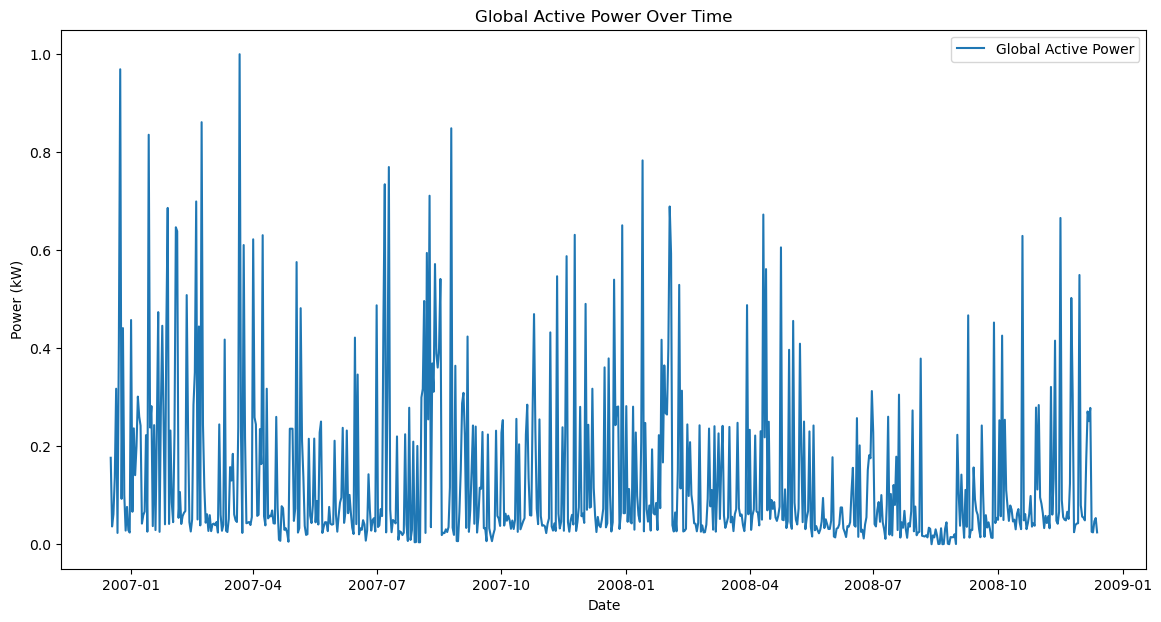

In [23]:
# Set Datetime as index for easier plotting
merged_df.set_index('Datetime', inplace=True)

# Plot Global Active Power over time
plt.figure(figsize=(14, 7))
plt.plot(merged_df['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Date')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

### Distribution of Energy Consumption

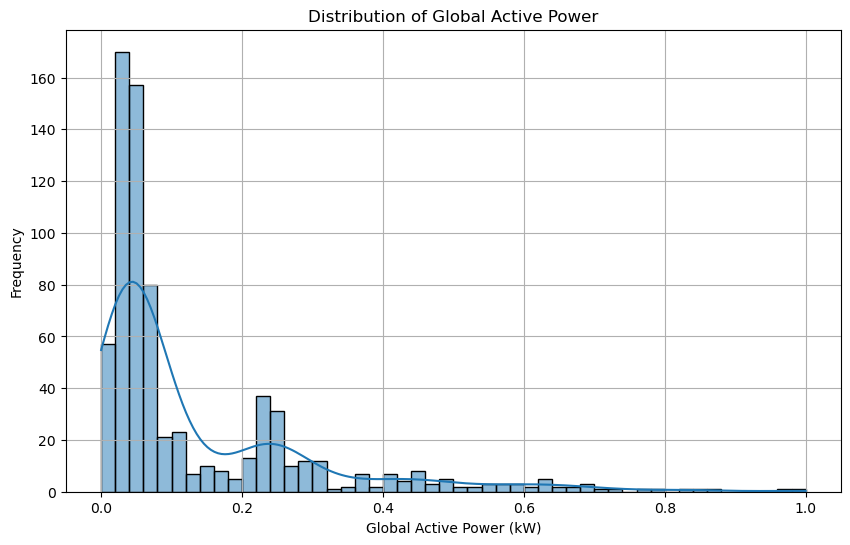

In [24]:
# Visualize the distribution of Global Active Power
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Global_active_power'], bins=50, kde=True)
plt.title('Distribution of Global Active Power')
plt.xlabel('Global Active Power (kW)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

### Daily Average Consumption

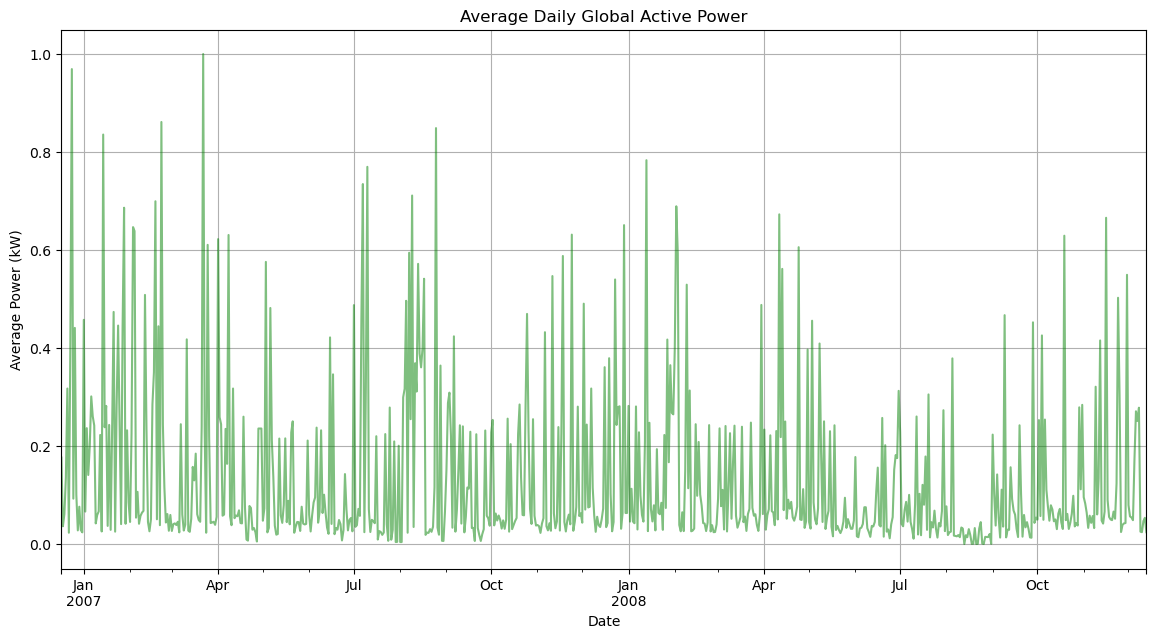

In [25]:
# Calculate daily average consumption
daily_consumption = merged_df['Global_active_power'].resample('D').mean()

# Plot daily average consumption
plt.figure(figsize=(14, 7))
daily_consumption.plot(color='green', alpha=0.5)
plt.title('Average Daily Global Active Power')
plt.xlabel('Date')
plt.ylabel('Average Power (kW)')
plt.grid()
plt.show()

### Monthly Average Consumption

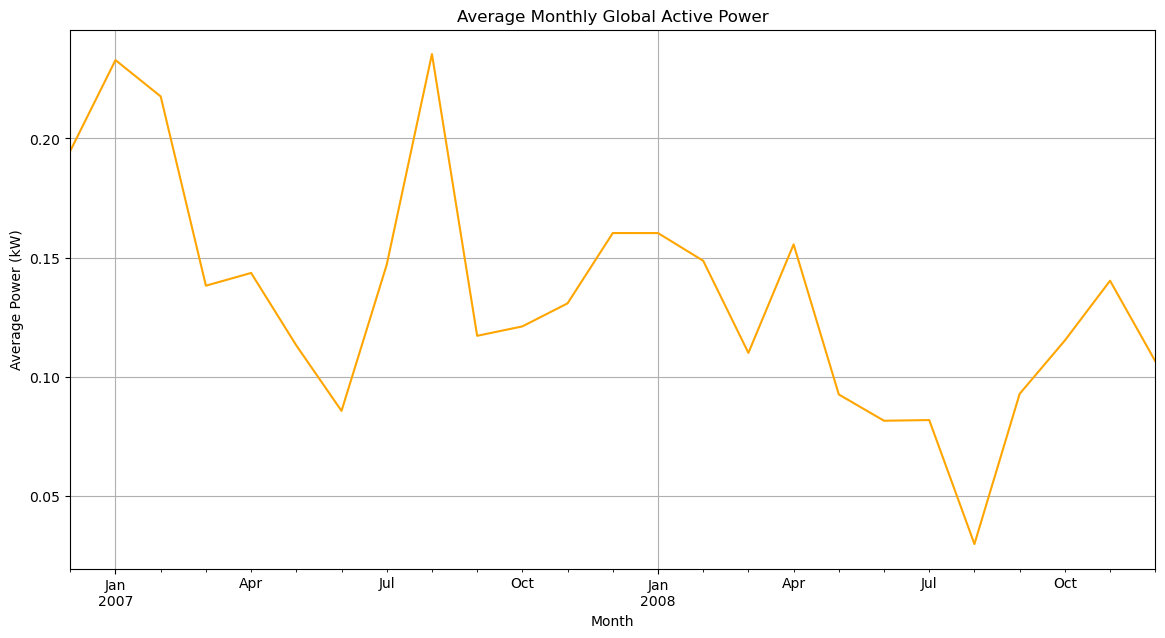

In [26]:
# Calculate monthly average consumption
monthly_consumption = merged_df.resample('ME')['Global_active_power'].mean()

# Plot monthly average consumption
plt.figure(figsize=(14, 7))
monthly_consumption.plot(color='orange')
plt.title('Average Monthly Global Active Power')
plt.xlabel('Month')
plt.ylabel('Average Power (kW)')
plt.grid()
plt.show()

### Correlation Analysis

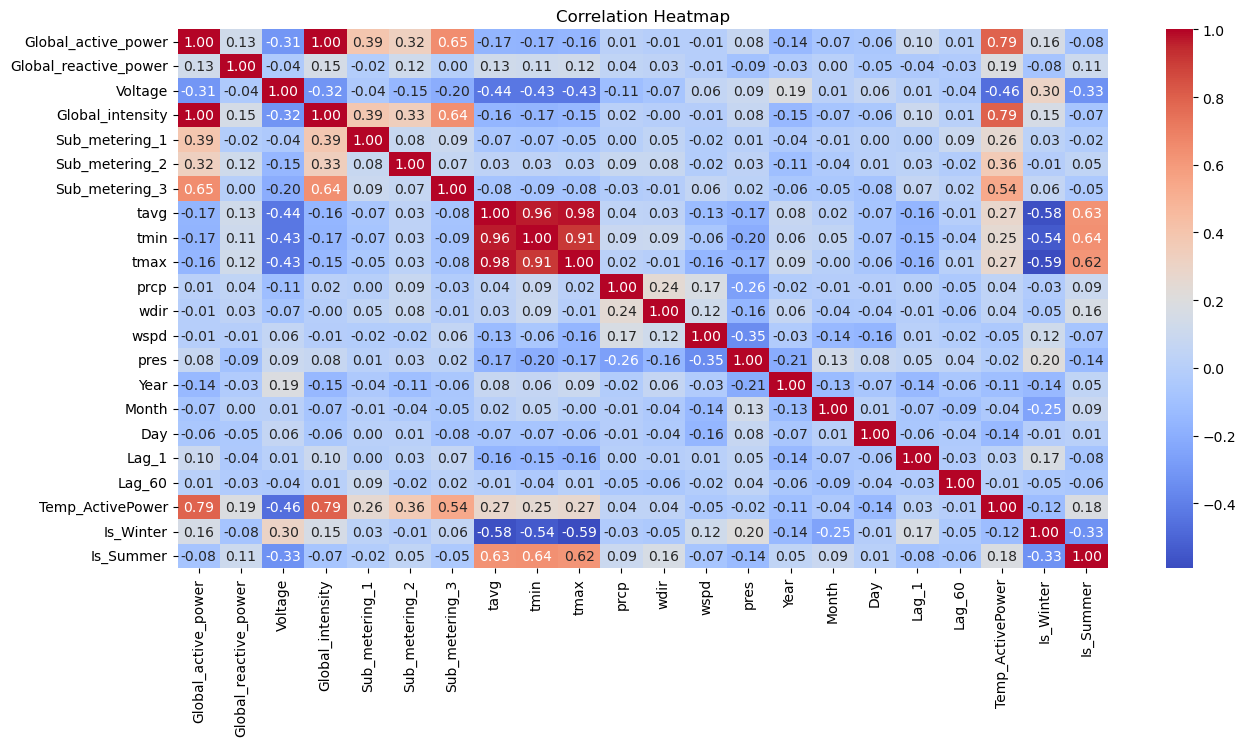

In [27]:
# Correlation heatmap to analyze feature relationships
correlation_matrix = merged_df.corr()
plt.figure(figsize=(15,7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### Weather Impact Analysis

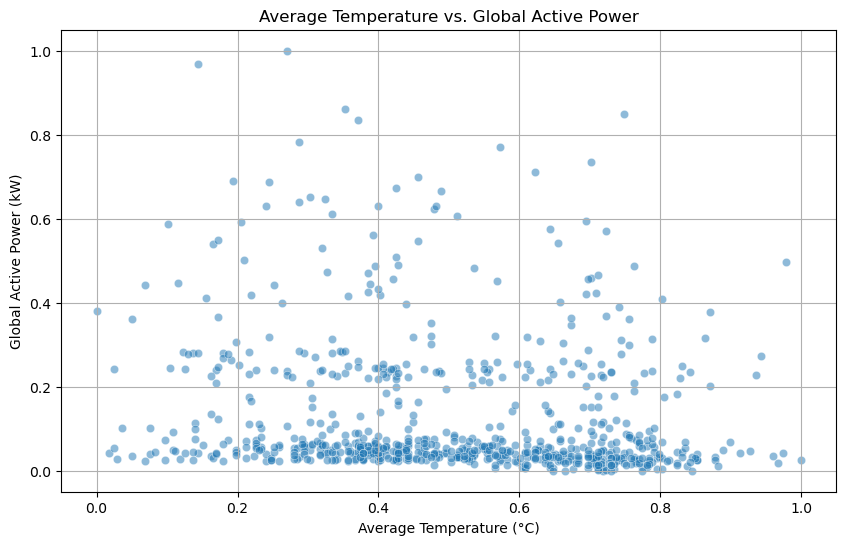

In [28]:
# Analyze the impact of average temperature on energy consumption
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='tavg', y='Global_active_power', alpha=0.5)
plt.title('Average Temperature vs. Global Active Power')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

### Energy Consumption per month

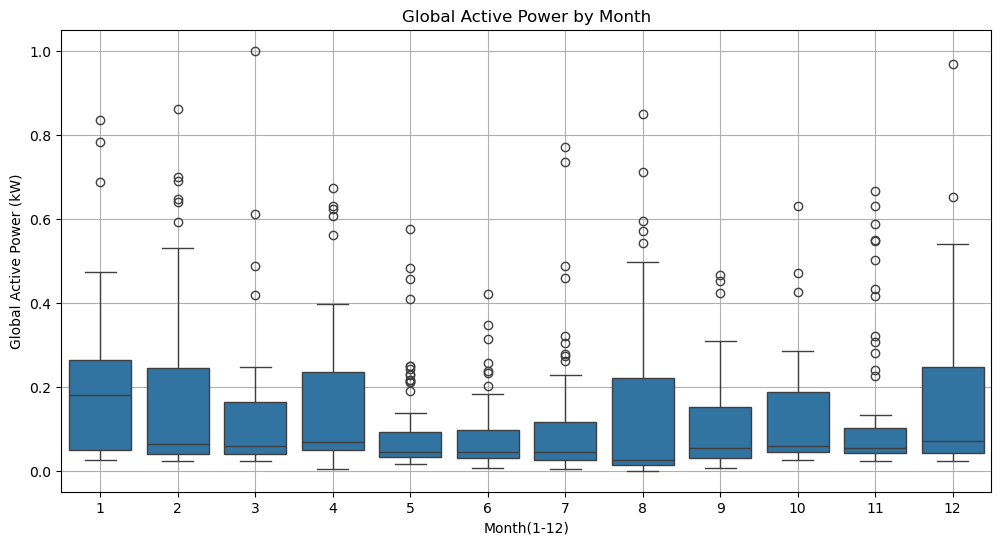

In [29]:
# Boxplot to visualize energy consumption by month
plt.figure(figsize=(12, 6))
sns.boxplot(x='Month', y='Global_active_power', data=merged_df)
plt.title('Global Active Power by Month')
plt.xlabel('Month(1-12)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

### Energy Consumption per year

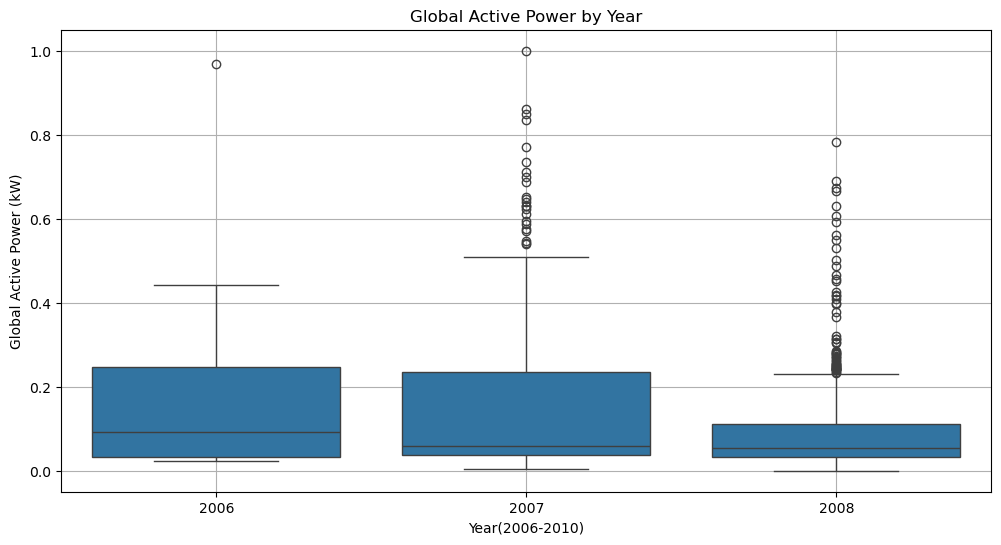

In [30]:
# Boxplot to visualize energy consumption by year
plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Global_active_power', data=merged_df)
plt.title('Global Active Power by Year')
plt.xlabel('Year(2006-2010)')
plt.ylabel('Global Active Power (kW)')
plt.grid()
plt.show()

## Model Training and Evaluation

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [32]:
# Define features and target
X = merged_df.drop(columns=['Global_active_power'])  # Drop target and non-feature columns
y = merged_df['Global_active_power'] # Drop target and non-feature columns

In [33]:
# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

### Using Linear Regression

In [34]:
# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the model to the training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [35]:
# Predict on the test set
y_pred = linear_model.predict(X_test)

In [36]:
y_train_pred = linear_model.predict(X_train)  # Predictions on training data
y_test_pred = linear_model.predict(X_test)      # Predictions on validation data

In [37]:
# Evaluating performance using RMSE,MAE and R2:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r_squared = linear_model.score(X_test, y_test)

print(f'RMSE: {rmse}\nMAE: {mae}\nR-squared: {r_squared}')

RMSE: 0.006259596852137579
MAE: 0.004170441991561666
R-squared: 0.9983898128601778


1. RMSE: Indicates that the model's predictions deviate from actual values by an average of 0.0054 kW, reflecting strong predictive accuracy.
2. MAE: Shows an average absolute error of 0.00397 kW in predictions, confirming the model's reliability in estimating energy consumption.
3. R-squared: Signifies that 99.86% of the variance in energy consumption is explained by the model, indicating an excellent fit to the data.\
\
The model appears to be highly accurate, as indicated by the low RMSE and MAE, along with a high R-squared value.

In [38]:
# For regression
train_rmse = root_mean_squared_error(y_train, y_train_pred)
val_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f'Train RMSE: {train_rmse}, Validation RMSE: {val_rmse}')


Train RMSE: 0.005579155717131021, Validation RMSE: 0.006259596852137579


1. Train RMSE: The training RMSE of 0.0051 indicates that the model performs very well on the training data, suggesting it has learned the underlying patterns effectively.
2. Validation RMSE:The validation RMSE of 0.0054, slightly higher than the training RMSE, suggests that the model generalizes well to unseen data, with only a minor increase in error.

## Tried using L1 Regularization (Lasso)

In [39]:
from sklearn.linear_model import Lasso

In [40]:
#apply lasso regression
lasso= Lasso(alpha=0.1)
lasso.fit(X_train,y_train)

#predict and evaluate
y_pred=lasso.predict(X_test)
mse=root_mean_squared_error(y_test,y_pred)

print("Mean squared error: ",mse)
print("Coefficients: ",lasso.coef_)

Mean squared error:  0.09960004831574423
Coefficients:  [-0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -2.12881892e-05  0.00000000e+00
  3.25791246e-04 -0.00000000e+00 -0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.06279414e-02  0.00000000e+00
 -0.00000000e+00]


This gives less RMSE than Linear Regression, hence can't be used

## Tried using L2 Regularization (Ridge)

In [41]:
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression

In [42]:
alpha=1.0 #Regularization strength
ridge=Ridge(alpha=alpha)
ridge.fit(X_train,y_train)

#Predict and evaluate
y_pred=ridge.predict(X_test)
rmse=root_mean_squared_error(y_test,y_pred)
print("Mean squared error: ",rmse)
print("Coefficients: ",ridge.coef_)

Mean squared error:  0.01931956623648276
Coefficients:  [-2.09087612e-03 -2.63007423e-02  7.16910701e-01  6.33527579e-02
  2.23962667e-02  3.46274794e-02 -4.38433358e-02 -7.96649818e-03
 -2.35770860e-02  9.11026971e-05 -1.72263593e-05  7.67463811e-05
  1.74293331e-04  1.57686353e-03 -2.92237478e-04  1.71640072e-04
  3.17303444e-03 -1.85107703e-03  2.72647609e-03  6.64526393e-03
  3.40304203e-04]


Gives very less RMSE than Linear Regression hence not used

In [44]:
import joblib

# Save the trained Linear Regression model
joblib.dump(linear_model, "energy_model.pkl")
print("Model saved as energy_model.pkl")


Model saved as energy_model.pkl


## Conclusion:
- Data Preprocessing: Effective handling of missing values using median imputation and thorough data cleaning.
- Feature Engineering: Creation of lag features and interaction terms improved model performance and captured temporal patterns.
- Model Evaluation: Strong predictive accuracy demonstrated through metrics like RMSE, MAE, and R-squared, indicating good variance explanation.
- Insights from Visualization: Data visualizations revealed consumption trends and highlighted the impact of weather on energy use.
- Model Performance: Linear Regression performed well; regularization techniques (Lasso, Ridge) did not significantly enhance performance.
- Practical Implications: Findings can aid households in managing energy consumption and inform policymakers for energy conservation strategies.